In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
path="/content/drive/MyDrive/Credit_Card/data_credit_card.csv"
credit_card_data = pd.read_csv(path)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from statistics import mean , stdev
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.model_selection import StratifiedKFold

!cp /content/drive/MyDrive/Credit_Card/model_Decision_Tree.py /content
!cp /content/drive/MyDrive/Credit_Card/model_KNN.py /content
!cp /content/drive/MyDrive/Credit_Card/model_Naive_Bayes.py /content
!cp /content/drive/MyDrive/Credit_Card/model_SVM.py /content
from model_KNN import KNN
from model_Naive_Bayes import NaiveBayes
from model_Decision_Tree import DecisionTree
from model_SVM import SVM


Định nghĩa hàm winsorise, hàm này có tác dụng xác định các điểm ngoại lai theo giá trị thuộc tính đầu vào attribute, sau đó sẽ xử lý các điểm ngoại lai này bằng cách thay đổi các giá trị này thành giá trị biên:

In [ ]:
def winsorize(data, attribute, alpha=0.05):
    sorted_data = data.sort_values(by=attribute)
    length = len(sorted_data)

    lower_cutoff_index = int(alpha / 2 * length)
    upper_cutoff_index = int((1 - alpha / 2) * length)

    lower_bound = sorted_data[attribute].iloc[lower_cutoff_index]
    upper_bound = sorted_data[attribute].iloc[upper_cutoff_index]

    winsorized_data = data.copy()

    winsorized_data[attribute] = np.where(winsorized_data[attribute] < lower_bound, lower_bound, np.where(winsorized_data[attribute] > upper_bound, upper_bound, winsorized_data[attribute]))

    return winsorized_data

Kiểm tra kích thước của tập dữ liệu:

In [ ]:
print(credit_card_data.shape)

(284807, 31)


In ra 5 dòng đầu tiên của dữ liệu:

In [ ]:
print("Fisrt 5 line: ")
print(credit_card_data.head(5))


Fisrt 5 line: 
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26      

Kiểm tra tổng quan về dữ liệu:

In [ ]:
print("Infor: ")
print(credit_card_data.info())
## Nhan thay cac bien deu co kieu du lieu la float va int

Infor: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V2

Vẽ đồ thị biểu diễn tỉ lệ nhãn là gian lận (1) và không gian lận (0):

Class as pie chart : 


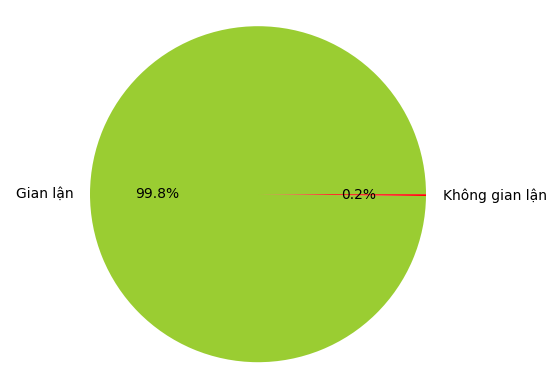

In [ ]:
print("Class as pie chart : ")
fix, ax = plt.subplots(1,1)
ax.pie(credit_card_data.Class.value_counts(), autopct='%1.1f%%',labels=['Gian lận','Không gian lận'],colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')
plt.show()

Kiểm tra sự phụ thuộc của nhãn vào thuộc tính Time, nhóm nhận thấy số lượng giao dịch thẻ tín dụng tăng lên vào ban ngày. Tuy nhiên, số lượng giao dịch là gian lận và không gian lận dường như có sự phụ thuộc tương tự nhau vào thời điểm trong ngày. Chính vì vậy nhóm quyết định loại bỏ cột thuộc tính Time ra khỏi dữ liệu, bởi nó dường như không mang lại bất cứ ý nghĩa nào cho việc phân loại.

Time variable :
0    0.000000
1    0.000000
2    0.000278
3    0.000278
4    0.000556
Name: Time_Hr, dtype: float64


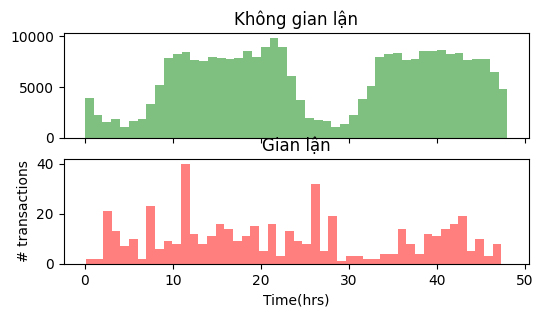

In [ ]:
print("Time variable :")
credit_card_data["Time_Hr"] = credit_card_data["Time"]/3600   #Chuyển sang giờ
print(credit_card_data["Time_Hr"].head(5))
fig,(ax1 , ax2) = plt.subplots(2, 1, sharex= True, figsize=(6,3))
ax1.hist(credit_card_data.Time_Hr[credit_card_data.Class==0], bins = 48, color= 'g', alpha=0.5)
ax1.set_title('Không gian lận')
ax2.hist(credit_card_data.Time_Hr[credit_card_data.Class==1], bins = 48, color='r',alpha=0.5)
ax2.set_title('Gian lận')
plt.xlabel('Time(hrs)')
plt.ylabel('# transactions')
plt.show()

Loại bỏ cột thuộc tính Time:

In [ ]:
credit_card_data = credit_card_data.drop(['Time'],axis=1)

Xét sự phụ thuộc của việc phân lớp nhãn với cột thuộc tính Amount:

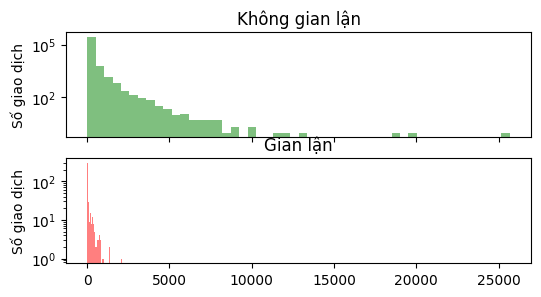

In [ ]:
fig, (ax3, ax4) = plt.subplots(2, 1, figsize = (6,3), sharex = True)
ax3.hist(credit_card_data.Amount[credit_card_data.Class==0], bins = 50, color = 'g', alpha = 0.5)
ax3.set_yscale('log')
ax3.set_title("Không gian lận")
ax3.set_ylabel("Số giao dịch")
ax4.hist(credit_card_data.Amount[credit_card_data.Class==1], bins = 50, color ='r', alpha = 0.5)
ax4.set_title("Gian lận")
ax4.set_yscale('log')
ax4.set_ylabel('Số giao dịch')
plt.show()


Xét sự phụ thuộc của việc phân loại nhãn vào các thuộc tính còn lại:

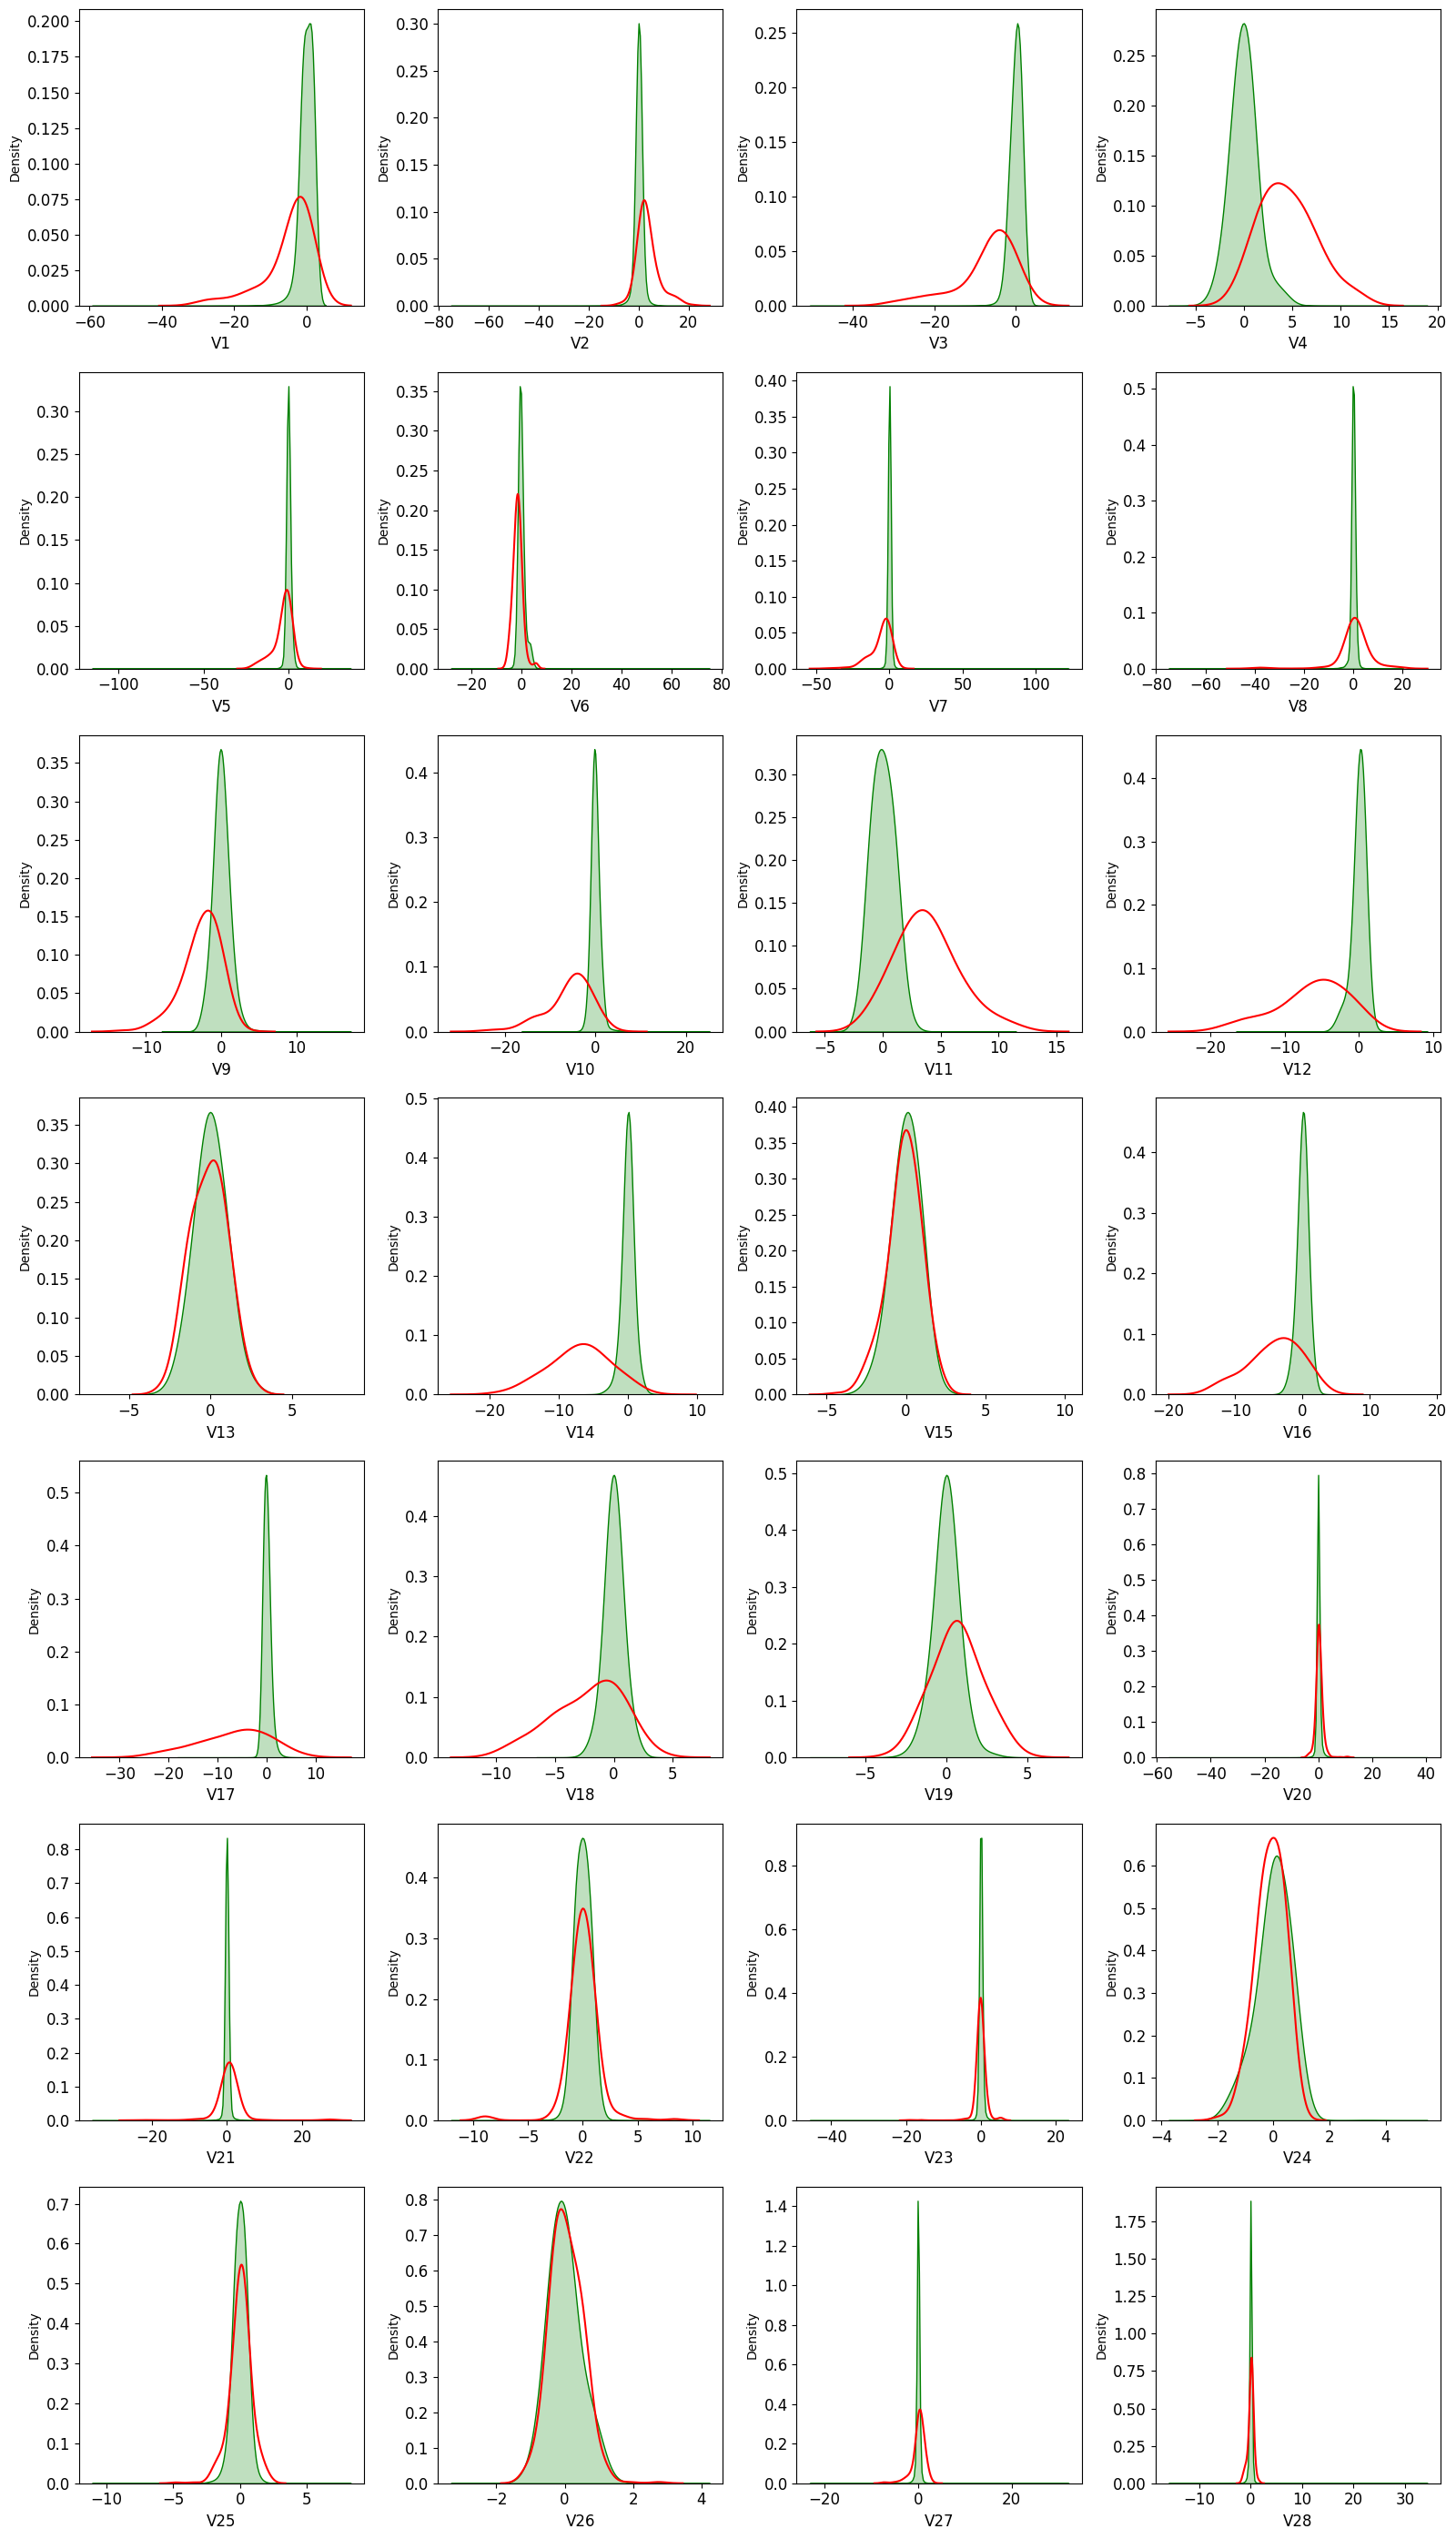

In [ ]:
t0 = credit_card_data.loc[credit_card_data['Class'] == 0]
t1 = credit_card_data.loc[credit_card_data['Class'] == 1]
var = list(credit_card_data.columns.values)
var.remove("Class")
var.remove("Time_Hr")
var.remove("Amount")
num_features = len(var)
num_rows = num_features // 4 + int(num_features % 4 != 0)

fig, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 28))

for idx, feature in enumerate(var):
    row = idx // 4
    col = idx % 4

    if row < ax.shape[0] and col < ax.shape[1]:
        sns.kdeplot(t0[feature], bw_method=0.5, label="Class = 0", color='g', fill=True, warn_singular=False, ax=ax[row, col])
        sns.kdeplot(t1[feature], bw_method=0.5, label="Class = 1", color='r', warn_singular=False, ax=ax[row, col])

        ax[row, col].set_xlabel(feature, fontsize=12)
        ax[row, col].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


Thực hiện quá trình winsorisation trên tập dữ liệu sau đó sử dụng Standard Scaler để chuẩn hóa giá trị của cột thuộc tính Amount (do giá trị của cột thuộc tính này rất lớn so với giá trị của các thuộc tính còn lại).
Do tập dữ liệu bị mất cân bằng rất lớn, đồng thời kích thước của tập dữ liệu cũng lớn, nhóm chọn sử dụng phương pháp Under Sampling để tạo ra tập dữ liệu mới gồm 492 giao dịch gian lận và 492 giao dịch không gian lận. Điều này giúp cải thiện tốc độ học cũng như tăng sự chính xác của việc dự đoán sau này.

Đồng thời nhóm giữ lại tập data ban đầu là X_ori và y_ori để sử dụng cho việc đánh giá hiệu quả của các model.

In [ ]:
credit_card_data = winsorize(credit_card_data,"Amount", 0.1)
scaler1 = StandardScaler()

credit_card_data['Vamount'] = scaler1.fit_transform(credit_card_data["Amount"].values.reshape(-1,1))

credit_card_data = credit_card_data.drop(["Amount"], axis = 1)

X_ori = credit_card_data.drop(["Class"], axis = 1)
y_ori = credit_card_data["Class"]

legit = credit_card_data[credit_card_data.Class == 0]
fraud = credit_card_data[credit_card_data.Class == 1]

legit_sample = legit.sample(n = 492, random_state = 421)


new_dataset = pd.concat([legit_sample, fraud], axis = 0)

new_dataset = winsorize(new_dataset,'Vamount', 0.15)

Từ các đồ thị đã vẽ ở trên, ta nhận thấy còn khá nhiều các thuộc tính dường như không mang lại ý nghĩa, hoặc mang lại ít ý nghĩa cho việc phân loại. Vì vậy nhóm chọn sử dụng phương pháp PCA để giảm số chiều của dữ liệu, giữ lại các đặc trưng có ý nghĩa chủ yếu trong việc phân loại dữ liệu.
Sau đó, nhóm sử dụng Standard Scaler một lần nữa để chuẩn hóa dữ liệu sau PCA.

In [ ]:
X = new_dataset.drop(["Class"], axis = 1)
y = new_dataset["Class"]

index = X.index
pca = PCA(n_components = 5)
principalComponents = pca.fit_transform(X)
principalDf  = pd.DataFrame(data = principalComponents, columns = ["PC1", "PC2","PC3","PC4","PC5"], index = index)

finalDf = pd.concat([principalDf, y], axis = 1)

X1 = finalDf.drop(columns="Class", axis = 1)
Y1 = finalDf["Class"]

X2 = X1.to_numpy()
Y2 = Y1.to_numpy()
scaler2 = StandardScaler()
X2 = scaler2.fit_transform(X2)
X_ori_pca = pca.transform(X_ori)
X_original = scaler2.transform(X_ori_pca)
y_original = y_ori
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)


Thực hiện quá trình đánh giá cho các model nhóm đã xây dựng, với 4 tiêu chí được lựa chọn là Accuracy, F1_Score, Precision và Recall:

In [ ]:
lm_accr = []
lm_recall = []
lm_precision = []
lm_f1_score = []

def evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    if (model_name == "SVM"):
        y_train_svm = np.where(y_train == 0, -1, 1)
        y_test_svm = np.where(y_test == 0, -1, 1)
        model.fit(X_train, y_train_svm)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test_svm, predictions)
        recall = recall_score(y_test_svm, predictions, zero_division=1)
        precision = precision_score(y_test_svm, predictions, zero_division=1)
        f1 = f1_score(y_test_svm, predictions, zero_division=1)
        return accuracy, recall, precision, f1
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        recall = recall_score(y_test, predictions, zero_division=1)
        precision = precision_score(y_test, predictions, zero_division=1)
        f1 = f1_score(y_test, predictions, zero_division=1)
        return accuracy, recall, precision, f1

models = {
    'Naive Bayes': NaiveBayes(),
    'SVM': SVM(),
    'KNN': KNN(),
    'Decision Tree': DecisionTree(),
}

for model_name, model_instance in models.items():
    lst_accr = []
    lst_recall = []
    lst_precision = []
    lst_f1_score = []

    lst_accr_ori = []
    lst_recall_ori = []
    lst_precision_ori = []
    lst_f1_score_ori = []

    for train_index, test_index in skf.split(X2, Y2):
        X_train, X_test = X2[train_index], X2[test_index]
        y_train, y_test = Y2[train_index], Y2[test_index]


        accr, recall, precision, f1 = evaluate_model(model_name, model_instance, X_train, y_train, X_test, y_test)
        lst_accr.append(accr)
        lst_recall.append(recall)
        lst_precision.append(precision)
        lst_f1_score.append(f1)

        accr, recall, precision, f1 = evaluate_model(model_name, model_instance, X_train, y_train, X_test, y_test)


        accr_ori, recall_ori, precision_ori, f1_ori = evaluate_model(model_name,model_instance, X_train, y_train, X_original, y_original)
        lst_accr_ori.append(accr_ori)
        lst_recall_ori.append(recall_ori)
        lst_precision_ori.append(precision_ori)
        lst_f1_score_ori.append(f1_ori)

    lm_accr.append(mean(lst_accr_ori))
    lm_recall.append(mean(lst_recall_ori))
    lm_precision.append(mean(lst_precision_ori))
    lm_f1_score.append(mean(lst_f1_score_ori))
    print(f"{model_name}: ")

    print("Mean of recall score: ", mean(lst_recall))
    print("Mean of precision score: ", mean(lst_precision))
    print("Mean of f1 score: ", mean(lst_f1_score))
    print("Mean of accuracy score: ", mean(lst_accr))
    print("")

    print(f"{model_name} on original data: ")
    print("Mean of recall score: ", mean(lst_recall_ori))
    print("Mean of precision score: ", mean(lst_precision_ori))
    print("Mean of f1 score: ", mean(lst_f1_score_ori))
    print("Mean of accuracy score: ", mean(lst_accr_ori))
    print("")


Naive Bayes: 
Mean of recall score:  0.8678829107400536
Mean of precision score:  0.9531085935341255
Mean of f1 score:  0.9080561305757935
Mean of accuracy score:  0.9125971200663007

Naive Bayes on original data: 
Mean of recall score:  0.8691056910569106
Mean of precision score:  0.03296174721731125
Mean of f1 score:  0.06351364404051893
Mean of accuracy score:  0.9557075493228748

SVM: 
Mean of recall score:  0.867862296433725
Mean of precision score:  0.9861311011161086
Mean of f1 score:  0.9226668747697143
Mean of accuracy score:  0.9278514451465866

SVM on original data: 
Mean of recall score:  0.8703252032520326
Mean of precision score:  0.1284084262047984
Mean of f1 score:  0.2222236431052803
Mean of accuracy score:  0.9888226061859434

KNN: 
Mean of recall score:  0.902473716759431
Mean of precision score:  0.9654206466048572
Mean of f1 score:  0.9326361945583761
Mean of accuracy score:  0.9349476846576193

KNN on original data: 
Mean of recall score:  0.9231707317073171
Mean 

Vẽ đồ thị so sánh hiệu năng giữa từng model:

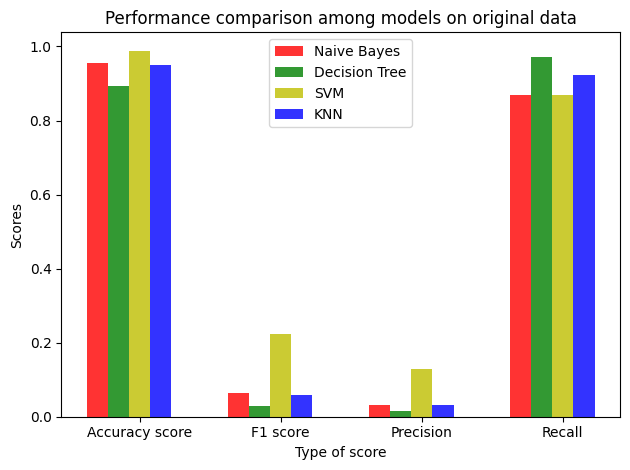

In [ ]:

n_groups = 4

naive_scores = np.array([np.mean(lm_accr[0]), np.mean(lm_f1_score[0]), np.mean(lm_precision[0]), np.mean(lm_recall[0])])
tree_scores = np.array([np.mean(lm_accr[3]), np.mean(lm_f1_score[3]), np.mean(lm_precision[3]), np.mean(lm_recall[3])])
svm_scores = np.array([np.mean(lm_accr[1]), np.mean(lm_f1_score[1]), np.mean(lm_precision[1]), np.mean(lm_recall[1])])
knn_scores = np.array([np.mean(lm_accr[2]), np.mean(lm_f1_score[2]), np.mean(lm_precision[2]), np.mean(lm_recall[2])])

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index - 0.3, naive_scores, bar_width, alpha=opacity, color='r', label='Naive Bayes')
rects2 = plt.bar(index - 0.15, tree_scores, bar_width, alpha=opacity, color='g', label='Decision Tree')
rects3 = plt.bar(index, svm_scores, bar_width, alpha=opacity, color='y', label='SVM')
rects4 = plt.bar(index + 0.15, knn_scores, bar_width, alpha=opacity, color='b', label='KNN')

plt.xlabel('Type of score')
plt.ylabel('Scores')
plt.title('Performance comparison among models on original data')
plt.xticks(index , ('Accuracy score', 'F1 score', 'Precision', 'Recall'))
plt.legend()
plt.tight_layout()
plt.show()

